In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'facial-emotion-expressions:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2876250%2F4959552%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240320%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240320T061843Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4ab35a0da06eb08476d519bace488a4ab6f4dd4baa6d741701678371a66d56e212e9fa3eb757b91b9678623553201698b2f7a429b352a4e6607658844ade03c16132be718e4ec04ae2ddb203bf765f60df79bf7476a3a5307805843473efdaea112bb347640c4de6f670bb512e414b52f1d7c309db19de7777833c61efd138f1c7dd2e2934eff8e9846110ace6e0c7314277250a09ff56d3b3261350fdc6f4b3fa510a5b19ffcbcad155b2005789c0b3f1fafc145c99443d89f600842152792cfd20e3bfb8ed3f570c3777719ce49801ee59af2f4a0e352dc8f49b723ae8e8556ff8e459afd49a8a764cd0a04981683789f16702e8c71ff695905f99f579e13b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 126358582 bytes downloaded
Downloaded and uncompressed: facial-emotion-expressions
Data source import complete.


# Import libraries, load and transform data

In [ ]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score
)

from imblearn.over_sampling import RandomOverSampler
import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)

In [ ]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# use https://huggingface.co/docs/datasets/image_load for reference

image_dict = {}
from pathlib import Path
from tqdm import tqdm
import os
file_names = []
labels = []

for file in sorted((Path('/kaggle/input/facial-emotion-expressions/images/images/').glob('*/*/*.*'))):
    sample_dir = '/'.join(str(file).split('/')[:-1])+'/'
    label = str(file).split('/')[-2]
    labels.append(label)
    file_names.append(str(file))

print(len(file_names), len(labels))
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

35887 35887
(35887, 2)


In [ ]:
df.head()

,image,label
0,/kaggle/input/facial-emotion-expressions/image...,angry
1,/kaggle/input/facial-emotion-expressions/image...,angry
2,/kaggle/input/facial-emotion-expressions/image...,angry
3,/kaggle/input/facial-emotion-expressions/image...,angry
4,/kaggle/input/facial-emotion-expressions/image...,angry


In [ ]:
y = df[['label']]
df = df.drop(['label'], axis=1)

ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y

df['label'] = y_resampled
del y_resampled
gc.collect()

print(df.shape)

(62923, 2)


In [ ]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

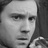

In [ ]:
dataset[0]["image"]

In [ ]:
labels_subset = labels[:5]
print(labels_subset)

['angry', 'angry', 'angry', 'angry', 'angry']


In [ ]:
labels_list = ['sad', 'disgust', 'angry', 'neutral', 'fear', 'surprise', 'happy']
label2id, id2label = dict(), dict()

# Assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'sad', 1: 'disgust', 2: 'angry', 3: 'neutral', 4: 'fear', 5: 'surprise', 6: 'happy'} 

Mapping of Labels to IDs: {'sad': 0, 'disgust': 1, 'angry': 2, 'neutral': 3, 'fear': 4, 'surprise': 5, 'happy': 6}


In [ ]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']

Map:   0%|          | 0/62923 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/62923 [00:00<?, ? examples/s]

In [ ]:
# Define the pre-trained ViT model string
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize((size, size)),
        RandomRotation(45),
        RandomAdjustSharpness(2),
        ToTensor(),
        normalize
    ]
)

_val_transforms = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        normalize
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Size:  224


In [ ]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [ ]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Load, train, and evaluate model

In [ ]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

85.804039


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {
        "accuracy": acc_score
    }

In [ ]:
metric_name = "accuracy"
model_name = "facial_emotions_image_detection"

num_train_epochs = 4

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=3e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=num_train_epochs,

    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',

    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.evaluate()

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.336800,0.306802,0.904132
2,0.311300,0.289964,0.911720
3,0.284200,0.291733,0.910052
4,0.277700,0.286781,0.912435


TrainOutput(global_step=4720, training_loss=0.30386128102318716, metrics={'train_runtime': 7171.2615, 'train_samples_per_second': 21.058, 'train_steps_per_second': 0.658, 'total_flos': 1.1702744752175899e+19, 'train_loss': 0.30386128102318716, 'epoch': 4.0})

In [ ]:
trainer.evaluate()

In [ ]:
outputs = trainer.predict(test_data)

print(outputs.metrics)

{'test_loss': 0.2867814302444458, 'test_accuracy': 0.9124354390147, 'test_runtime': 372.8526, 'test_samples_per_second': 67.507, 'test_steps_per_second': 16.878}


Accuracy: 0.9124
F1 Score: 0.9124


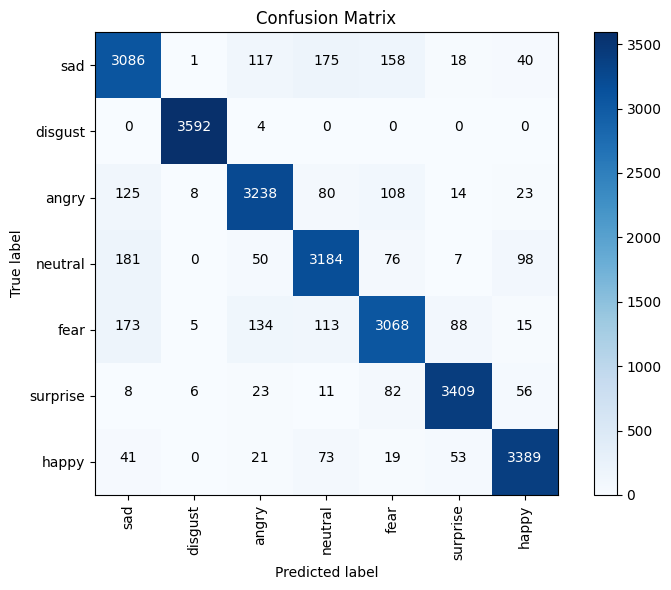


Classification report:

              precision    recall  f1-score   support

         sad     0.8539    0.8584    0.8562      3595
     disgust     0.9945    0.9989    0.9967      3596
       angry     0.9027    0.9004    0.9016      3596
     neutral     0.8757    0.8854    0.8805      3596
        fear     0.8738    0.8532    0.8634      3596
    surprise     0.9498    0.9483    0.9491      3595
       happy     0.9359    0.9424    0.9392      3596

    accuracy                         0.9124     25170
   macro avg     0.9123    0.9124    0.9124     25170
weighted avg     0.9123    0.9124    0.9124     25170



In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [ ]:
trainer.save_model()

In [ ]:
from transformers import pipeline
pipe = pipeline('image-classification', model=model_name, device=0)

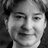

In [ ]:
image = test_data[1]["image"]
image

In [ ]:
pipe(image)

[{'label': 'happy', 'score': 0.9144682288169861},
 {'label': 'neutral', 'score': 0.06467537581920624},
 {'label': 'angry', 'score': 0.006134511437267065},
 {'label': 'sad', 'score': 0.006095003802329302},
 {'label': 'surprise', 'score': 0.004195789806544781}]

In [ ]:
id2label[test_data[1]["label"]]

'happy'